In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
from itertools import cycle

import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

import optuna

c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.config.list_physical_devices("GPU")

[]

In [4]:
pwd = os.getcwd()
pwd

'd:\\Research Projects\\HEA\\Featurize_New_Alloys\\HEA'

In [5]:
df = pd.read_csv(pwd+"/raw_dataset/HEA_tr_NETCORE.csv")
print("Shape of Dataframe: ", df.shape)
df.head()

Shape of Dataframe:  (1167, 44)


,Alloy,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled,Phase
0,Al0.5NbTaTiV,3.838070,3290.0,584.546173,7.571474,0.966843,4.555556,4,121,170,3.912023,2.391138,153,1.63,1.572222,0.916291,1.777778,0.693147,0.111111,0.180262,4,2.666667,0.635989,1.797913,1.609438,8,8,0.908856,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.777778,9,5,4,43,3,BCC
1,Al0.75MoNbTiV,3.255577,2896.0,521.067701,7.571474,1.140210,4.263158,4,121,164,3.784190,2.377029,153,2.16,1.713158,0.932164,1.578947,0.693147,0.157895,0.235805,5,2.947368,0.845714,0.598806,1.609438,8,8,1.074312,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,221.000000,9,5,5,43,3,BCC
2,Al0.25MoNbTiV,3.205911,2896.0,441.662561,7.571474,0.758442,4.411765,4,121,164,3.784190,1.950841,153,2.16,1.725294,0.932164,1.529412,0.693147,0.058824,0.105014,5,3.294118,0.758442,0.492669,1.609438,8,8,0.833360,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,5,43,3,BCC
3,Al0.25NbTaTiV,3.825406,3290.0,539.821730,7.571474,0.648931,4.647059,4,121,170,3.912023,2.140270,153,1.63,1.570000,0.916291,1.764706,0.693147,0.058824,0.105014,4,2.823529,0.542163,1.825219,1.609438,8,8,0.718768,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,4,43,3,BCC
4,Al0.2MoTaTiV,3.838178,3290.0,565.511565,7.571474,0.703300,4.666667,4,121,170,3.912023,2.105461,153,2.16,1.702857,0.916291,1.761905,0.693147,0.047619,0.086822,5,3.095238,0.645547,1.812332,1.609438,8,8,0.829650,6,2.639771,1.809927,2.639771,0.0,0.0,0.000023,194,229,220.476191,9,5,5,43,3,BCC


In [6]:
# SHUFFLE THE DATASET
df = df.sample(frac=1, random_state=42)
X = df.copy().drop(columns=["Alloy", "Phase"])
y = df["Phase"].astype("category")
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1167, 42)
Shape of labels: (1167,)


In [7]:
# check class imbalance
print(y.value_counts(ascending=False))

Phase
MIP        428
BCC        363
FCC        211
FCC_BCC    165
Name: count, dtype: int64


In [8]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE(random_state=42).fit_resample(X, y)
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1712, 42)
Shape of labels: (1712,)


c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [9]:
# check for class imbalance
print(y.value_counts(ascending=False))

Phase
BCC        428
FCC        428
FCC_BCC    428
MIP        428
Name: count, dtype: int64


In [10]:
# SCALE FEATURES
X = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)
X.head()

,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled
0,0.161097,1.256140,0.606754,0.532601,0.521256,-0.216360,0.0,0.0,0.18,0.584759,0.717467,1.363636,0.25,0.232362,0.449317,-1.196825,0.000000,0.477222,0.422557,0.000000,-0.304043,0.175303,-0.008391,0.000000,0.000000,0.0,0.190333,1.333333,0.000000,0.000000,0.336801,0.000,0.000000,0.0,0.0,0.0,0.640823,0.000000,0.0,0.0,0.000000,0.0
1,-0.709468,-0.647368,-0.538152,-0.471801,-0.863198,0.220453,0.0,1.0,-0.42,-0.427776,-1.279471,0.000000,0.05,1.471545,1.916202,-0.110975,0.584963,-0.223215,-0.254527,-0.666667,1.487024,-0.236945,-0.963679,0.560099,-0.333333,-0.5,-0.196263,-0.333333,0.000000,10.948033,-0.030237,0.000,0.000000,0.0,-53.0,0.0,-0.640578,-0.333333,-0.2,1.0,0.666667,-1.0
2,-0.551801,-0.647368,-0.934202,0.039657,-0.977210,-0.216360,0.0,0.0,-0.70,-0.814217,-1.599888,0.000000,0.00,1.090976,1.916202,1.809577,0.000000,0.026149,0.020301,0.000000,0.584874,-0.225051,-0.802636,0.560099,-0.333333,-0.5,-0.853525,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,-0.694305,-0.666667,0.0,0.0,0.666667,-1.0
3,0.428073,2.882456,0.969928,-1.266392,0.594814,-1.406341,-1.0,-15.0,-0.42,1.434420,1.058207,-0.272727,0.64,0.850365,0.000000,0.362050,0.584963,1.529725,1.115875,0.000000,-0.534503,0.775456,0.299071,-1.247204,0.000000,0.0,0.262099,0.000000,-79.249736,4.490789,-0.030237,4.496,0.616735,0.0,0.0,0.0,-0.283342,0.333333,0.0,0.0,0.000000,0.0
4,0.071655,1.256140,0.363886,0.039657,0.103571,0.140634,0.0,0.0,0.18,0.584759,0.646848,0.000000,0.25,0.820978,0.449317,-0.535416,0.000000,0.161471,0.153797,0.000000,0.067211,0.047385,-0.120768,0.000000,0.000000,0.0,-0.141745,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,0.269152,0.000000,0.0,0.0,0.000000,0.0


In [11]:
# Label encode y and then to_categorical
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(y)

In [12]:
labels = list(lb_enc.classes_)
labels

['BCC', 'FCC', 'FCC_BCC', 'MIP']

In [13]:
print(dict(zip(lb_enc.inverse_transform([0, 1, 2, 3]), [0, 1, 2, 3])))

{'BCC': 0, 'FCC': 1, 'FCC_BCC': 2, 'MIP': 3}


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of test features: {X_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

Shape of training features: (1369, 42)
Shape of training labels: (1369,)
Shape of test features: (343, 42)
Shape of test labels: (343,)


In [15]:
# DEFINE OBJECTIVE FUNCTION
def obj_fn(trial):
    # DEFINE PARAMETER SPACE
    params = {
        "n_estimators":     trial.suggest_int("n_estimators", 100, 1100, step=100),
        "learning_rate":    trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth":        trial.suggest_int("max_depth", 3, 10),
        "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "booster":          trial.suggest_categorical("booster", ['dart', 'gbtree', 'gblinear']),
        "reg_alpha":        trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda":       trial.suggest_float("reg_lambda", 0, 5),
        "base_score":       trial.suggest_float("base_score", 0.1, 1, log=True),
        "gamma":            trial.suggest_float("gamma", 0.5, 1.0, step=0.1),
        
    }
    # CONSTRUCT MODEL
    model = XGBClassifier(**params, device="cuda", random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    return test_acc

In [15]:
# PERFORM BAYESIAN OPTIMIZATION
tpe = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=tpe)
study.optimize(obj_fn, n_trials=50, show_progress_bar=True)

[I 2024-10-01 03:54:17,945] A new study created in memory with name: no-name-26520741-effd-4918-83ea-9659070cbde3
  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
Best trial: 0. Best value: 0.466472:   2%|▏         | 1/50 [00:00<00:36,  1.35it/s]c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)

[I 2024-10-01 03:54:18,685] Trial 0 finished with value: 0.46647230320699706 and parameters: {'n_estimators': 800, 'learning_rate': 0.087218321944043, 'max_depth': 3, 'subsample': 0.819349748386129, 'colsample_bytree': 0.9378421460322415, 'booster': 'gblinear', 'reg_alpha': 0.8005368956914517, 'reg_lambda': 3.607784419968623, 'base_score': 0.8101132068093162, 'gamma': 0.9}. Best is trial 0 with value: 0.46647230320699706.


Best trial: 0. Best value: 0.466472:   4%|▍         | 2/50 [00:00<00:20,  2.39it/s]

[I 2024-10-01 03:54:18,879] Trial 1 finished with value: 0.39941690962099125 and parameters: {'n_estimators': 300, 'learning_rate': 0.011879662475217649, 'max_depth': 6, 'subsample': 0.9735850839747724, 'colsample_bytree': 0.9242206553088779, 'booster': 'gblinear', 'reg_alpha': 0.9743584474644688, 'reg_lambda': 3.575021776747516, 'base_score': 0.1451654582728413, 'gamma': 0.9}. Best is trial 0 with value: 0.46647230320699706.


c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
Best trial: 2. Best value: 0.848397:   6%|▌         | 3/50 [00:11<03:51,  4.92s/it]

[I 2024-10-01 03:54:29,165] Trial 2 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 100, 'learning_rate': 0.05453693991636257, 'max_depth': 10, 'subsample': 0.6750441486636795, 'colsample_bytree': 0.9272479625791492, 'booster': 'dart', 'reg_alpha': 0.668033913116916, 'reg_lambda': 4.036077018055043, 'base_score': 0.952324588745238, 'gamma': 0.6}. Best is trial 2 with value: 0.8483965014577259.


Best trial: 3. Best value: 0.857143:   8%|▊         | 4/50 [00:14<03:21,  4.39s/it]

[I 2024-10-01 03:54:32,731] Trial 3 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 400, 'learning_rate': 0.025400302532218685, 'max_depth': 8, 'subsample': 0.9805988785637061, 'colsample_bytree': 0.5375547839784436, 'booster': 'gbtree', 'reg_alpha': 0.7376153957846875, 'reg_lambda': 1.8417363230207073, 'base_score': 0.2751789895460002, 'gamma': 0.5}. Best is trial 3 with value: 0.8571428571428571.


Best trial: 3. Best value: 0.857143:  10%|█         | 5/50 [05:12<1:22:29, 109.99s/it]c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:59:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-10-01 03:59:29,969] Trial 4 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 500, 'learning_rate': 0.09977943816487668, 'max_depth': 7, 'subsample': 0.8419954906927715, 'colsample_bytree': 0.5316650853615826, 'booster': 'dart', 'reg_alpha': 0.5840747487487086, 'reg_lambda': 3.1765602350340423, 'base_score': 0.8264145548697338, 'gamma': 1.0}. Best is trial 3 with value: 0.8571428571428571.


Best trial: 3. Best value: 0.857143:  12%|█▏        | 6/50 [05:12<53:23, 72.80s/it]   c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:59:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-10-01 03:59:30,571] Trial 5 finished with value: 0.46647230320699706 and parameters: {'n_estimators': 800, 'learning_rate': 0.014613556722411495, 'max_depth': 4, 'subsample': 0.5251384511405726, 'colsample_bytree': 0.7227042802885328, 'booster': 'gblinear', 'reg_alpha': 0.7903942345128431, 'reg_lambda': 0.8939069824520457, 'base_score': 0.8674324929502627, 'gamma': 0.8}. Best is trial 3 with value: 0.8571428571428571.


Best trial: 3. Best value: 0.857143:  14%|█▍        | 7/50 [05:13<35:16, 49.21s/it]

[I 2024-10-01 03:59:31,223] Trial 6 finished with value: 0.39941690962099125 and parameters: {'n_estimators': 800, 'learning_rate': 0.027689402984273907, 'max_depth': 5, 'subsample': 0.9396398820282671, 'colsample_bytree': 0.9000815079156568, 'booster': 'gblinear', 'reg_alpha': 0.9931759941864348, 'reg_lambda': 1.1872621248843802, 'base_score': 0.9877098194983789, 'gamma': 1.0}. Best is trial 3 with value: 0.8571428571428571.


Best trial: 3. Best value: 0.857143:  16%|█▌        | 8/50 [05:16<24:14, 34.64s/it]

[I 2024-10-01 03:59:34,658] Trial 7 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 300, 'learning_rate': 0.012093090964602218, 'max_depth': 6, 'subsample': 0.7303067546651449, 'colsample_bytree': 0.5811326913056003, 'booster': 'gbtree', 'reg_alpha': 0.8504849602385907, 'reg_lambda': 1.3685728989602164, 'base_score': 0.27975480679122183, 'gamma': 0.8}. Best is trial 3 with value: 0.8571428571428571.


Best trial: 3. Best value: 0.857143:  18%|█▊        | 9/50 [05:22<17:31, 25.64s/it]

[I 2024-10-01 03:59:40,518] Trial 8 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 500, 'learning_rate': 0.01257057844777905, 'max_depth': 9, 'subsample': 0.6039306159733332, 'colsample_bytree': 0.5039049321704199, 'booster': 'gbtree', 'reg_alpha': 0.01719419746485873, 'reg_lambda': 0.712629766077772, 'base_score': 0.29503438148867134, 'gamma': 0.9}. Best is trial 3 with value: 0.8571428571428571.


Best trial: 3. Best value: 0.857143:  20%|██        | 10/50 [07:16<35:16, 52.90s/it]

[I 2024-10-01 04:01:34,466] Trial 9 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 300, 'learning_rate': 0.03417959883460274, 'max_depth': 9, 'subsample': 0.689064255257898, 'colsample_bytree': 0.9375470642255415, 'booster': 'dart', 'reg_alpha': 0.015167646091957754, 'reg_lambda': 3.6371847422875265, 'base_score': 0.10848541751070975, 'gamma': 0.8}. Best is trial 3 with value: 0.8571428571428571.


Best trial: 10. Best value: 0.87172:  22%|██▏       | 11/50 [07:23<25:19, 38.95s/it]

[I 2024-10-01 04:01:41,784] Trial 10 finished with value: 0.8717201166180758 and parameters: {'n_estimators': 1000, 'learning_rate': 0.023122603207097376, 'max_depth': 8, 'subsample': 0.8748856806971467, 'colsample_bytree': 0.6585957786850217, 'booster': 'gbtree', 'reg_alpha': 0.2982699063435083, 'reg_lambda': 2.2039542598781883, 'base_score': 0.4724960714308555, 'gamma': 0.5}. Best is trial 10 with value: 0.8717201166180758.


Best trial: 11. Best value: 0.874636:  24%|██▍       | 12/50 [07:31<18:35, 29.36s/it]

[I 2024-10-01 04:01:49,209] Trial 11 finished with value: 0.8746355685131195 and parameters: {'n_estimators': 1100, 'learning_rate': 0.023884463547364412, 'max_depth': 8, 'subsample': 0.8870767418965113, 'colsample_bytree': 0.6487913508163682, 'booster': 'gbtree', 'reg_alpha': 0.3532011297684418, 'reg_lambda': 2.1645224833237244, 'base_score': 0.46897364490677806, 'gamma': 0.5}. Best is trial 11 with value: 0.8746355685131195.


Best trial: 11. Best value: 0.874636:  26%|██▌       | 13/50 [07:38<13:57, 22.64s/it]

[I 2024-10-01 04:01:56,371] Trial 12 finished with value: 0.8717201166180758 and parameters: {'n_estimators': 1100, 'learning_rate': 0.02010384980333216, 'max_depth': 8, 'subsample': 0.8741977937138653, 'colsample_bytree': 0.6537695961808461, 'booster': 'gbtree', 'reg_alpha': 0.3639464984251667, 'reg_lambda': 2.594681842156873, 'base_score': 0.4913698802187557, 'gamma': 0.5}. Best is trial 11 with value: 0.8746355685131195.


Best trial: 11. Best value: 0.874636:  28%|██▊       | 14/50 [07:44<10:34, 17.62s/it]

[I 2024-10-01 04:02:02,384] Trial 13 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 1100, 'learning_rate': 0.04183427159203035, 'max_depth': 7, 'subsample': 0.7992627318799894, 'colsample_bytree': 0.8171490954094749, 'booster': 'gbtree', 'reg_alpha': 0.32245604085031476, 'reg_lambda': 4.895804276708614, 'base_score': 0.49881647204341056, 'gamma': 0.6}. Best is trial 11 with value: 0.8746355685131195.


Best trial: 11. Best value: 0.874636:  30%|███       | 15/50 [07:51<08:22, 14.35s/it]

[I 2024-10-01 04:02:09,160] Trial 14 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 1000, 'learning_rate': 0.01831463939966794, 'max_depth': 10, 'subsample': 0.8931363982718781, 'colsample_bytree': 0.6729236921225241, 'booster': 'gbtree', 'reg_alpha': 0.244351876262887, 'reg_lambda': 0.061208943014059436, 'base_score': 0.48187209117455926, 'gamma': 0.6}. Best is trial 11 with value: 0.8746355685131195.


Best trial: 11. Best value: 0.874636:  32%|███▏      | 16/50 [07:57<06:44, 11.89s/it]

[I 2024-10-01 04:02:15,347] Trial 15 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 900, 'learning_rate': 0.020402328291466827, 'max_depth': 8, 'subsample': 0.9160358252991776, 'colsample_bytree': 0.7834522143492324, 'booster': 'gbtree', 'reg_alpha': 0.4411654173762195, 'reg_lambda': 2.198666140933618, 'base_score': 0.38636031670130605, 'gamma': 0.5}. Best is trial 11 with value: 0.8746355685131195.


Best trial: 11. Best value: 0.874636:  34%|███▍      | 17/50 [08:01<05:16,  9.59s/it]

[I 2024-10-01 04:02:19,599] Trial 16 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 700, 'learning_rate': 0.045438518751820284, 'max_depth': 9, 'subsample': 0.7630638202257178, 'colsample_bytree': 0.6324171710264083, 'booster': 'gbtree', 'reg_alpha': 0.172594155755525, 'reg_lambda': 2.8032045741423084, 'base_score': 0.18362883984715672, 'gamma': 0.7}. Best is trial 11 with value: 0.8746355685131195.


Best trial: 11. Best value: 0.874636:  36%|███▌      | 18/50 [08:06<04:17,  8.05s/it]

[I 2024-10-01 04:02:24,062] Trial 17 finished with value: 0.8658892128279884 and parameters: {'n_estimators': 1000, 'learning_rate': 0.06595298957539353, 'max_depth': 7, 'subsample': 0.864016563780979, 'colsample_bytree': 0.7163280300231206, 'booster': 'gbtree', 'reg_alpha': 0.5077961083075359, 'reg_lambda': 1.8855816717093616, 'base_score': 0.5871229769342019, 'gamma': 0.7}. Best is trial 11 with value: 0.8746355685131195.


Best trial: 18. Best value: 0.877551:  38%|███▊      | 19/50 [08:11<03:47,  7.35s/it]

[I 2024-10-01 04:02:29,791] Trial 18 finished with value: 0.8775510204081632 and parameters: {'n_estimators': 1000, 'learning_rate': 0.032902887706280415, 'max_depth': 5, 'subsample': 0.7756065577301237, 'colsample_bytree': 0.5966484698612133, 'booster': 'gbtree', 'reg_alpha': 0.15967969580737595, 'reg_lambda': 1.7304891694168458, 'base_score': 0.6588637336226814, 'gamma': 0.6}. Best is trial 18 with value: 0.8775510204081632.


Best trial: 18. Best value: 0.877551:  40%|████      | 20/50 [46:46<5:50:03, 700.12s/it]

[I 2024-10-01 04:41:04,493] Trial 19 finished with value: 0.8746355685131195 and parameters: {'n_estimators': 1100, 'learning_rate': 0.03376822079249425, 'max_depth': 5, 'subsample': 0.6235351530262347, 'colsample_bytree': 0.6130027887303, 'booster': 'dart', 'reg_alpha': 0.13575063749134397, 'reg_lambda': 1.7071526784470588, 'base_score': 0.626664025203514, 'gamma': 0.6}. Best is trial 18 with value: 0.8775510204081632.


Best trial: 18. Best value: 0.877551:  42%|████▏     | 21/50 [47:44<4:05:11, 507.28s/it]

[I 2024-10-01 04:42:02,182] Trial 20 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 900, 'learning_rate': 0.01648035544121736, 'max_depth': 3, 'subsample': 0.7891031088997028, 'colsample_bytree': 0.5785790164233776, 'booster': 'gbtree', 'reg_alpha': 0.19134623199598372, 'reg_lambda': 0.34093941947173523, 'base_score': 0.3728775307592303, 'gamma': 0.7}. Best is trial 18 with value: 0.8775510204081632.


Best trial: 18. Best value: 0.877551:  44%|████▍     | 22/50 [1:54:47<12:09:06, 1562.38s/it]

[I 2024-10-01 05:49:05,064] Trial 21 finished with value: 0.8775510204081632 and parameters: {'n_estimators': 1100, 'learning_rate': 0.034394466028388394, 'max_depth': 5, 'subsample': 0.6090382100809112, 'colsample_bytree': 0.5982328171975221, 'booster': 'dart', 'reg_alpha': 0.16096043018805353, 'reg_lambda': 1.4635258795765873, 'base_score': 0.6463153134653234, 'gamma': 0.6}. Best is trial 18 with value: 0.8775510204081632.


In [16]:
best_model_params = study.best_params
best_model_params

{'n_estimators': 500,
 'learning_rate': 0.09482522378166337,
 'max_depth': 6,
 'subsample': 0.8264915876833466,
 'colsample_bytree': 0.5191166881321312,
 'booster': 'gbtree',
 'reg_alpha': 0.36193430376388297,
 'reg_lambda': 0.03174570819448254,
 'base_score': 0.1603758415920753,
 'gamma': 0.6}

In [17]:
# BUILD MODEL USING BEST PARAMETERS AND EVALUATE
best_model = XGBClassifier(**best_model_params, device="cuda", random_state=42)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# CLASSIFICATION REPORT
print("Classification Report on Training Data")
print("-"*80)
print(classification_report(y_train, y_train_pred, target_names=labels, digits=4))

print("Classification Report on Test Data")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=labels, digits=4))

# EVALUATE ROC-AUC SCORE
pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
print("-"*80)
print(f"ROC-AUC SCORE: {roc_auc*100: .4f} %")

Classification Report on Training Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.9262    0.9631    0.9443       352
         FCC     0.9673    0.9644    0.9658       337
     FCC_BCC     0.9543    0.9795    0.9667       341
         MIP     0.9685    0.9056    0.9360       339

    accuracy                         0.9533      1369
   macro avg     0.9541    0.9531    0.9532      1369
weighted avg     0.9538    0.9533    0.9531      1369

Classification Report on Test Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.9315    0.8947    0.9128        76
         FCC     0.8901    0.8901    0.8901        91
     FCC_BCC     0.8830    0.9540    0.9171        87
         MIP     0.8471    0.8090    0.8276        89

    accuracy                         0.8863       343
   

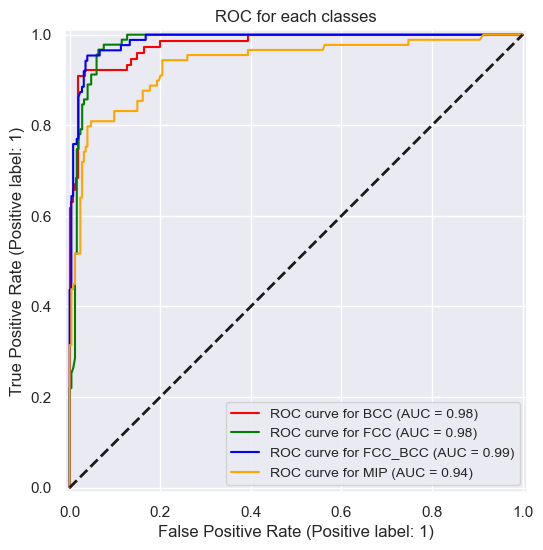

In [18]:
# PLOT ROC CURVE
fig, ax = plt.subplots(figsize=(6, 6))
y_test_oh = to_categorical(y_test)
colors = cycle(["red", "green", "blue", "orange"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test_oh[:, class_id],
        pred_proba[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.legend(loc='lower right', fontsize='10')
plt.title("ROC for each classes")
plt.savefig(pwd+"/figures/xgb_roc_curve.png", dpi=600, bbox_inches="tight")

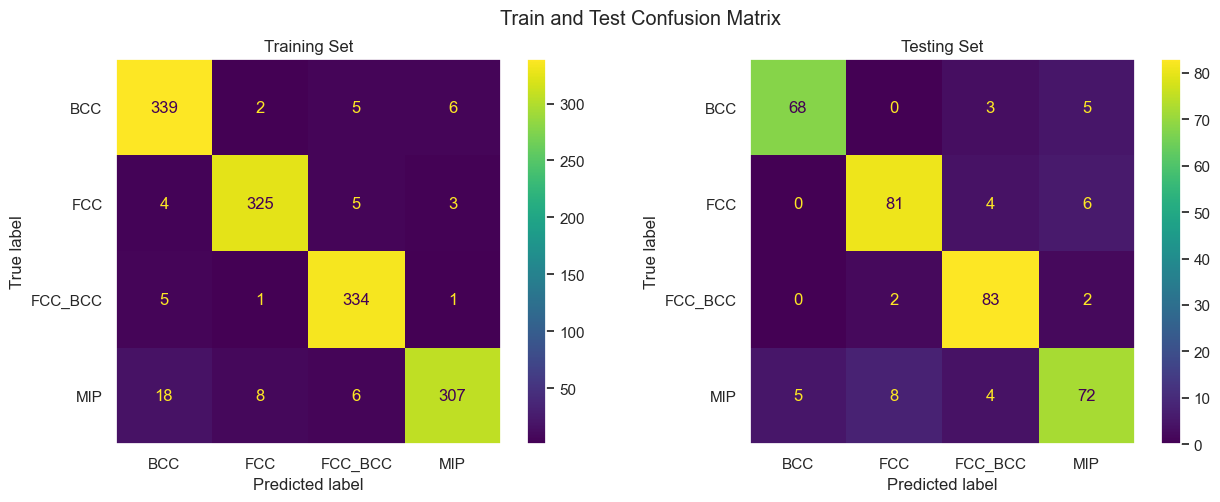

In [19]:
# CONFUSION MATRIX
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
f,(ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_train.plot(ax = ax1)
disp_test.plot(ax = ax2)
ax1.set_title('Training Set')
ax2.set_title('Testing Set')
ax1.grid(False)
ax2.grid(False)
plt.suptitle('Train and Test Confusion Matrix')
plt.savefig(pwd+"/figures/xgb_cf.png", dpi=600, bbox_inches="tight")

# ACCURACY PER CLASS
acc_class_train = cm_train.diagonal() / cm_train.sum(axis=1)
acc_class_test = cm_test.diagonal() / cm_test.sum(axis=1)

print("Training accuracy per class:", acc_class_train)
print("Testing accuracy per class:", acc_class_test)

In [20]:
# 10 FOLD CROSS VALIDATION
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X, y):
    X_train_cv, y_train_cv = X.iloc[train_idx], y[train_idx]
    X_test_cv, y_test_cv = X.iloc[test_idx], y[test_idx]
    best_model.fit(X_train_cv, y_train_cv)
    y_test_pred_cv = best_model.predict(X_test_cv)
    score = accuracy_score(y_test_cv, y_test_pred_cv)
    cv_scores.append(score*100)

print("Cross Validation Score")
print("-"*50)
print(f"Mean Accuracy: {np.mean(cv_scores): .4f} % \nStandard Deviation: (+/-){np.std(cv_scores): .4f} %")
print("-"*50)

Cross Validation Score
--------------------------------------------------
Mean Accuracy:  86.8571 % 
Standard Deviation: (+/-) 2.2830 %
--------------------------------------------------
